In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from sklearn.preprocessing import OneHotEncoder 

In [2]:
encoder = OneHotEncoder()
encoder.fit([[0], [1], [2], [3]]) 

# 0 - Tumor
# 1 - pituitary
# 2 - giloma
# 3 - meningioma

OneHotEncoder()

In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 224
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 72.85it/s]


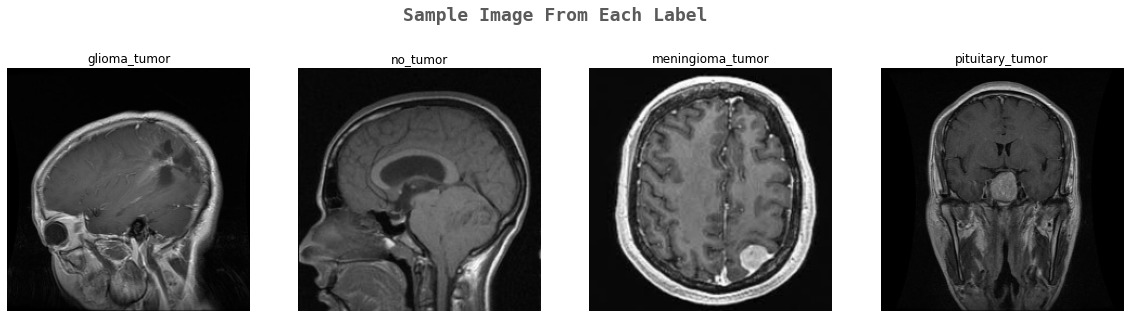

In [5]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [6]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [7]:
X_train.shape

(3264, 224, 224, 3)

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

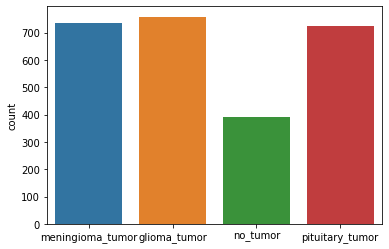

In [10]:
sns.countplot(y_train)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

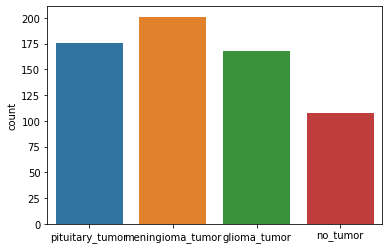

In [11]:
sns.countplot(y_test)

In [12]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [13]:
effnet = EfficientNetB1(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

2022-05-02 09:23:42.413703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 09:23:42.521699: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 09:23:42.522505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 09:23:42.523696: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

27033600/27018416 [==============================] - 0s 0us/step


In [14]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [16]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [17]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode='auto',verbose=1)

2022-05-02 09:23:48.719439: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-02 09:23:48.719483: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-05-02 09:23:48.721165: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-05-02 09:23:48.926262: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-02 09:23:48.926470: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [18]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =10, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-05-02 09:23:50.163794: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-05-02 09:24:03.022782: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1/74 [..............................] - ETA: 23:10 - loss: 1.5503 - accuracy: 0.2812

2022-05-02 09:24:09.635181: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-05-02 09:24:09.635246: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/74 [..............................] - ETA: 1:14 - loss: 1.3321 - accuracy: 0.4375 

2022-05-02 09:24:10.300045: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-05-02 09:24:10.303018: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-05-02 09:24:10.473354: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 3017 callback api events and 3014 activity events. 
2022-05-02 09:24:10.551460: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-05-02 09:24:10.653369: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_05_02_09_24_10

2022-05-02 09:24:10.701783: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_05_02_09_24_10/21a15f66e31f.trace.json.gz
2022-05-02 09:24:10.847478: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/pl

74/74 [==============================] - 46s 376ms/step - loss: 0.4570 - accuracy: 0.8374 - val_loss: 0.5970 - val_accuracy: 0.8321

Epoch 00001: val_accuracy improved from -inf to 0.83206, saving model to effnet.h5
Epoch 2/10
74/74 [==============================] - 23s 317ms/step - loss: 0.1589 - accuracy: 0.9476 - val_loss: 0.3242 - val_accuracy: 0.8931

Epoch 00002: val_accuracy improved from 0.83206 to 0.89313, saving model to effnet.h5
Epoch 3/10
74/74 [==============================] - 23s 318ms/step - loss: 0.1294 - accuracy: 0.9557 - val_loss: 0.3713 - val_accuracy: 0.8969

Epoch 00003: val_accuracy improved from 0.89313 to 0.89695, saving model to effnet.h5
Epoch 4/10
74/74 [==============================] - 23s 314ms/step - loss: 0.0767 - accuracy: 0.9732 - val_loss: 0.3946 - val_accuracy: 0.9160

Epoch 00004: val_accuracy improved from 0.89695 to 0.91603, saving model to effnet.h5
Epoch 5/10
74/74 [==============================] - 23s 314ms/step - loss: 0.0881 - accuracy: 

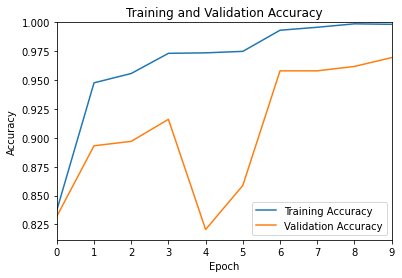

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlim([0,9])
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

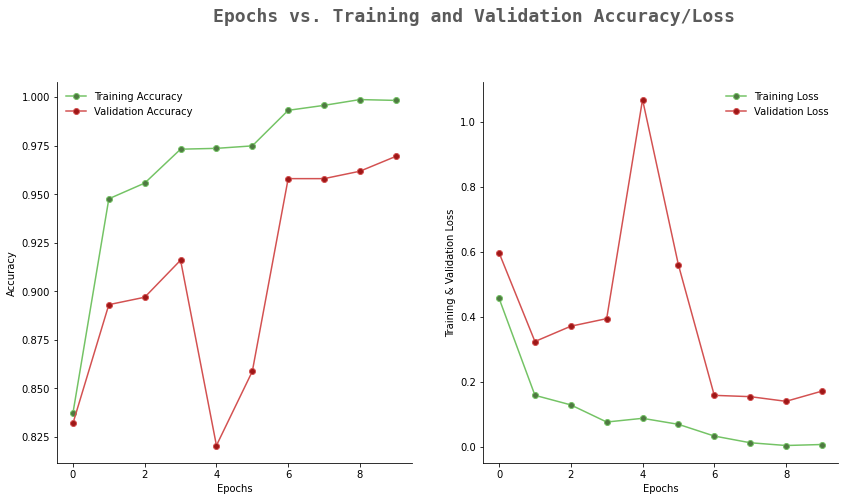

In [20]:
filterwarnings('ignore')

epochs = [i for i in range(10)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color='#313131',y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor='#4F7942',color='#74C365',
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor='#9E1717',color='#D35151',
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [21]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [22]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       168
           1       0.96      1.00      0.98       108
           2       0.98      0.98      0.98       201
           3       0.99      1.00      0.99       176

    accuracy                           0.98       653
   macro avg       0.98      0.98      0.98       653
weighted avg       0.98      0.98      0.98       653



In [23]:
cm = confusion_matrix(y_test_new, pred)

In [24]:
import itertools
from itertools import product
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


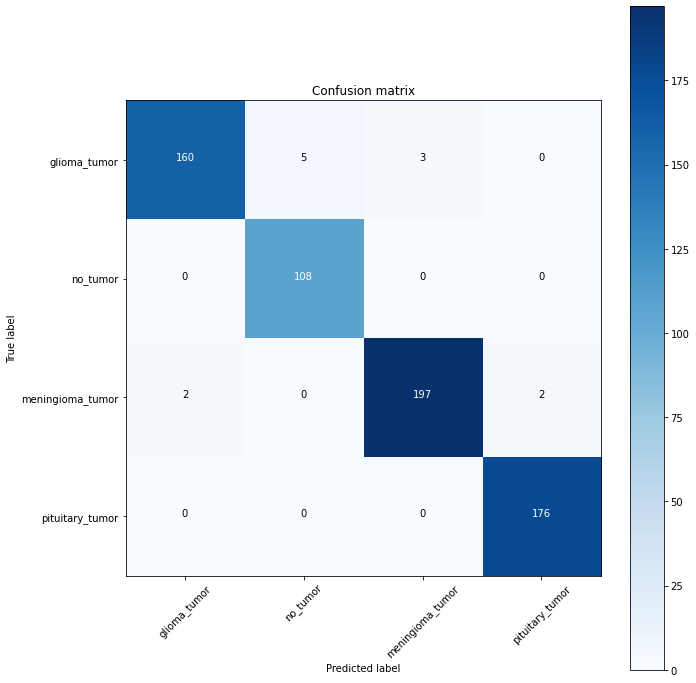

In [25]:
plot_confusion_matrix(cm,labels)


# Checking Model

In [26]:
def names(number):
    if number==0:
        return 'Its a Giloma Tumor'
    elif number==1:
        return ' Its not a Tumor'
    elif number==3:
        return ' Its a Pituitary  tumor'
    if number==2 :
        return ' Its a Meningioma tumor'
 

99.9994158744812% Confidence This Is  Its not a Tumor


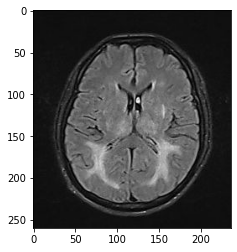

In [27]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-tumor-classification-mri/Testing/no_tumor/image(10).jpg")
x = np.array(img.resize((224,224)))
x = x.reshape(1,224,224,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

99.94304776191711% Confidence This Is  Its a Pituitary  tumor


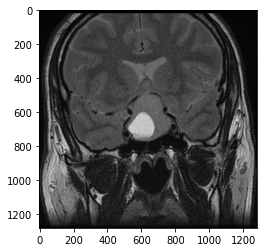

In [28]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-tumor-classification-mri/Testing/pituitary_tumor/image(15).jpg")
x = np.array(img.resize((224,224)))
x = x.reshape(1,224,224,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))

99.99396800994873% Confidence This Is  Its a Meningioma tumor


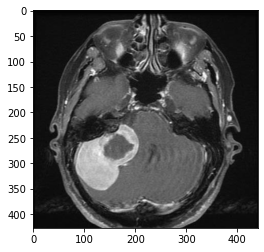

In [29]:
from matplotlib.pyplot import imshow
img = Image.open(r"../input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(121).jpg")
x = np.array(img.resize((224,224)))
x = x.reshape(1,224,224,3)
res = model.predict_on_batch(x)
classification = np.where(res == np.amax(res))[1][0]
imshow(img)
print(str(res[0][classification]*100) + '% Confidence This Is ' + names(classification))